In [1]:
import time
from faceKeySrc import load_data
import numpy as np
from sklearn.cross_validation import train_test_split
import lasagne
import theano.tensor as T
import theano
import matplotlib.pyplot as plt
from matplotlib import style
%matplotlib inline

Using gpu device 0: GeForce GTX 960 (CNMeM is disabled, cuDNN 5005)
/usr/local/lib/python2.7/dist-packages/theano/tensor/signal/downsample.py:6: UserWarning: downsample module has been moved to the theano.tensor.signal.pool module.
  "downsample module has been moved to the theano.tensor.signal.pool module.")


In [2]:
style.use('ggplot')

In [3]:
FTRAIN = '../data/training.csv'
FTEST = '../data/test.csv'
# load training data
data_X, data_Y = load_data(FTRAIN)

just drop all the samples with missing values, consider a better approach


In [4]:
# generate test validation split
train_set_x, valid_set_x, train_set_y, valid_set_y = train_test_split(
    data_X, data_Y, test_size=0.3, random_state=42
)

In [5]:
train_set_x = train_set_x.astype(theano.config.floatX)
train_set_y = train_set_y.astype(theano.config.floatX)
valid_set_x = valid_set_x.astype(theano.config.floatX)
valid_set_y = valid_set_y.astype(theano.config.floatX)
#########################################
# try it later to see if it improves the performance
# # store traiing data into shared variable
# train_set_x, train_set_y = shared_dataset(train_set_x, train_set_y)
# valid_set_x, valid_set_y = shared_dataset(valid_set_x, valid_set_y)

### linear regression with multiple outputs

In [6]:
def build__model(width,
                 num_output,
                 drop_input= None,
                 drop_hidden = None,
                 input_var=None):

    # Input layer and dropout (with shortcut `dropout` for `DropoutLayer`):
    network = lasagne.layers.InputLayer(shape=(None, 9216),
                                        input_var=input_var)
    if drop_input:
        network = lasagne.layers.dropout(network, p=drop_input)
    # Hidden layers and dropout:
    nonlin = lasagne.nonlinearities.rectify
    for i in range(len(width)):
        network = lasagne.layers.DenseLayer(
            network, width[i], nonlinearity=nonlin)
        if drop_hidden:
            network = lasagne.layers.dropout(network, p=drop_hidden[0])
            drop_hidden = drop_hidden[1:]
        
    # Output layer:
    out_nonlin = lasagne.nonlinearities.identity
    network = lasagne.layers.DenseLayer(network, num_output, nonlinearity=out_nonlin)
        
    return network

In [7]:
def reinitiate_set_params(network,
                          weights = None):
        # change weights of a trained network to a random set or a user defined value
        # useful in case of big networks and cross validation
        # instead of the long time of recompiling you can just 
        # re-init the network weights
        if not weights:
            old = lasagne.layers.get_all_param_values(network)
            weights = []
            for layer in old:
                shape = layer.shape
                if len(shape)<2:
                    shape = (shape[0], 1)
                W= lasagne.init.GlorotUniform()(shape)
                if W.shape != layer.shape:
                    W = np.squeeze(W, axis= 1)
                weights.append(W)
        lasagne.layers.set_all_param_values(network, weights) 
        return network

In [14]:
def build_update_functions(network,
                           y,
                           l2_reg = .1,
                           learning_rate = .005,
                           momentum = .9):
    # build update functions
    #####################################
    # extract tensor representing the network predictions
    prediction = lasagne.layers.get_output(network)
    loss = 0
    # collect squared error
    loss = lasagne.objectives.squared_error(prediction, y)
    # compute the root mean squared errror
    loss = loss.mean().sqrt()
    # add l2 regularization
    l2_penalty = lasagne.regularization.regularize_network_params(network,
                                                                  lasagne.regularization.l2)
    loss = (1-l2_reg) * loss + l2_reg * l2_penalty
    # get network params
    params = lasagne.layers.get_all_params(network)
    
#     # create update criterion    
#     print('nestrov')
#     updates = lasagne.updates.nesterov_momentum(
#         loss, params, learning_rate=learning_rate, momentum=momentum)
    
    print('AdaGrad')
    updates = lasagne.updates.adagrad(loss, params)
    
#     print('RMSPROP')
#     updates = lasagne.updates.rmsprop(loss, params)
    # create validation/test loss expression
    # the loss represents the loss for all the lables
    test_prediction = lasagne.layers.get_output(network,
                                                deterministic=True)
    # collect squared error
    test_loss = lasagne.objectives.squared_error(test_prediction,
                                                 y)
    # compute the root mean squared errror
    test_loss = test_loss.mean().sqrt()
    test_loss_withl2 = (1-l2_reg) * test_loss + l2_reg * l2_penalty
    # training function 
    
    train_fn = theano.function(inputs=[X,y],
                               outputs=loss,
                               updates=updates)
    # validation function 
    val_fn = theano.function(inputs=[X,y],
                             outputs=[test_loss_withl2,test_loss,prediction])
    return train_fn,val_fn

In [15]:
X = T.matrix('X')
y = T.matrix('y')
network = build__model([1024],
                       num_output=train_set_y.shape[1],
                       drop_input=.2,
                       drop_hidden=[.4],
                       input_var = X)

In [16]:
train_fn,val_fn = build_update_functions(network=network,
                                         y=y)

AdaGrad


In [17]:
# parasms 
n_iter = 10000
improvement_threshold = 0.999
patience = 20
max_fail = 10
########################
n_fail_ = 0
best_val_loss_ = np.inf
best_epoch_ = 0 
epoch = 0
done_looping = False
train_loss_history_ = []
val_loss_history_ =[]

In [18]:
start_time = time.time()
while (epoch < n_iter) and (not done_looping):            
            epoch += 1
            if (epoch % 200) == 0:
                print 'val loss l2',val_loss,'val loss',val_RMSE,'epoch',epoch,'n_fail',n_fail_,'in', time.time()-start_time,'SECs'
                start_time = time.time()

            # one ful epoch on training data
            train_loss = train_fn(train_set_x, train_set_y)
            
            # And a full pass over the validation data:
            val_loss,val_RMSE,_ = val_fn(valid_set_x, valid_set_y)
                                   
            # save trainin history
            train_loss_history_.append(train_loss)
            val_loss_history_.append(val_loss)

            # check for early stopping

            if np.mean(val_loss) < np.mean(best_val_loss_) * improvement_threshold:
                best_val_loss_ = val_loss
                best_epoch_ = epoch 
                best_network_params = lasagne.layers.get_all_param_values(network)
                # you can later init a network with this weights by set_all_params_values
                # it contains both W and b of all layers
                n_fail_ = 0
            elif (epoch % patience)==0:
                n_fail_ += 1        
            
            if n_fail_ == max_fail : 
                done_looping = True
                reinitiate_set_params(network=network,
                                      weights = best_network_params)
                break

val loss l2 99.5470123291 val loss 0.078136228025 epoch 200 n_fail 0 in 19.4824538231 SECs
val loss l2 32.4692955017 val loss 0.070584371686 epoch 400 n_fail 0 in 19.6563100815 SECs
val loss l2 13.3744573593 val loss 0.068152345717 epoch 600 n_fail 0 in 19.7122011185 SECs
val loss l2 6.09785461426 val loss 0.0680482909083 epoch 800 n_fail 0 in 19.754912138 SECs
val loss l2 2.94962096214 val loss 0.0678168833256 epoch 1000 n_fail 0 in 19.7296819687 SECs
val loss l2 1.49065995216 val loss 0.06775572896 epoch 1200 n_fail 0 in 19.6779158115 SECs
val loss l2 0.784226953983 val loss 0.0675714612007 epoch 1400 n_fail 0 in 19.5560798645 SECs
val loss l2 0.433112919331 val loss 0.0676616951823 epoch 1600 n_fail 0 in 19.3949038982 SECs
val loss l2 0.254728972912 val loss 0.0674587637186 epoch 1800 n_fail 0 in 19.3917200565 SECs
val loss l2 0.16304539144 val loss 0.0675649046898 epoch 2000 n_fail 0 in 19.4066698551 SECs
val loss l2 0.11490227282 val loss 0.0673891827464 epoch 2200 n_fail 0 in 19.

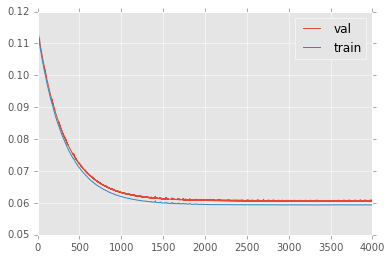

In [25]:
plt.plot(val_loss_history_[-4000:]);
plt.plot(train_loss_history_[-4000:]);
plt.legend(['val','train'])

### make a submission 

### CNN 